In [1]:
import kwant 
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, asdict
from kwant.continuum import discretize  
sx = np.array([[0 , 1] , [1 , 0]])
sy = np.array([[0 , -1j] , [1j , 0]])
sz = np.array([[1 , 0] , [0 , -1]])
id = np.array([[1 , 0] , [0 , 1]])

### In this notebook:
We calculate the magnitude of the bulk gap versus the Zeeman term in the Hamiltonian.

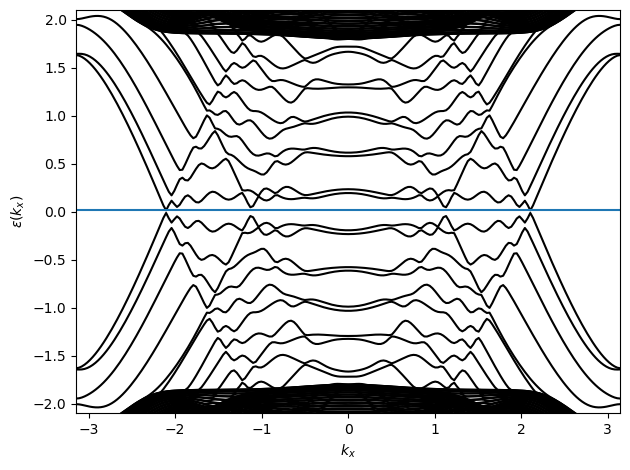

In [30]:
from scipy import constants
from sympy import exp
from josephson_current_tools import constants
@dataclass
class parameters:
    a : float # Lattice constant
    L_x : float # Dimension of planar system in x direction
    L_y : float # Dimension of planar system in y direction
    W : float # Width of the normal region in y direction
    m_eff : float # Effective mass
    mu : float # Chemical potential  
    alpha : float # Rashba coupling
    E_z : float # In plane Zeeman
    Delta : float # Superconducting gap
    phase : float # Phase bias of Josephson junction
    k : float # Boltzmann constant
    T : float # Temperature
    current_unit: float # Current unit

def make_lead(params, plot):
    # Continuum model:
    hamiltonian_bottom = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + Delta*kron(sigma_x , sigma_0)"""

    hamiltonian_top = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + 0.5*Delta*exp1*kron(sigma_x + I*sigma_y , sigma_0) 
    + 0.5*Delta*exp2*kron(sigma_x - I*sigma_y , sigma_0) 
    """

    template_sc_top = discretize(hamiltonian_top , locals = {'exp1' : np.exp(1j*params.phase) , 'exp2': np.exp(-1j*params.phase) } ,  grid = params.a )
    template_sc_bottom = discretize(hamiltonian_bottom , grid = params.a)
    template_normal = discretize(hamiltonian_bottom , locals =  {'Delta' : 0 , 'E_z' : 0 } , grid = params.a)

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))

    # Modified shape functions for a translationall invariant lead in the x-direction:
    half_w = params.W // 2
    half_L_y = params.L_y // 2

    def normal_region_color(site):
        if normal_region(site) == True:
            return 'red'
        else: 
            return 'blue'

    def normal_region(site):
        (x , y) = site.pos
        return ((half_L_y - half_w)< y < (half_L_y + half_w))
    
    def bottom_super_region(site):
        (x , y) = site.pos
        return (0 <=y <= (half_L_y - half_w))
    
    def top_super_region(site):
        (x , y) = site.pos
        return ((half_L_y + half_w)  <= y < params.L_y)
    
    lead.fill(template_sc_bottom , bottom_super_region , (0 , 0) )
    lead.fill(template_normal , normal_region , (0 , (half_L_y - half_w) + 1))
    lead.fill(template_sc_top , top_super_region , (0 , (half_L_y + half_w)))

    if plot == True:
        kwant.plot(lead , site_lw = 0.1 ,  site_color = normal_region_color );
    return lead.finalized()

params_ = parameters(a = 0.5 , L_x = 0, L_y = 45 , W  = 5 , m_eff = 2, mu = 2.5 , alpha = 0.5 , E_z= 0.2 , Delta = 2 , phase = np.pi*0.5, k = constants.k , T = 0.05 , current_unit = constants.current_unit)
syst  = make_lead(params_ , plot = False)

# Plotting band structure of the Josephson junction: 
bands = kwant.physics.Bands(syst , params = asdict(params_))
momenta = np.linspace(-np.pi , np.pi , 201)
energies = [bands(k) for k in momenta]
energies_moduus = np.abs(energies)
E_gap = np.min(energies_moduus)
fig , ax = plt.subplots()
ax.plot(momenta , energies , color = 'k');
ax.set_xlim(left = -np.pi , right = np.pi)
ax.set_ylim(bottom = -params_.Delta - 0.1 , top = params_.Delta + 0.1)
ax.set_xlabel(r'$k_{x}$')
ax.set_ylabel(r'$\epsilon(k_{x})$')
ax.axhline(E_gap)
plt.tight_layout()